In [1]:
import os
import io
import datetime
import requests

import numpy as np
import pandas as pd
import geopandas as gp

from tqdm import tqdm

# GET reservoir storage for nearby reservoirs 

In [2]:
def get_res_storage(reservoir_ids):
    '''
    Query CA DWR website to get MONTHLY reservoir storage for an area of interest
    '''
    print("**** Begin Fetching CDEC Reservoir Storage Data****")


    # Download Storage (SensorNums = 15) data by query str:
    start = datetime.datetime(1997, 1, 1)
    end = datetime.datetime(2022, 1, 1)
    dt_idx = pd.date_range(start,end, freq='MS')

    data = {}

    for i in tqdm(reservoir_ids):
        # print("processing " + i )
        url = "https://cdec.water.ca.gov/dynamicapp/req/CSVDataServlet?Stations={}&SensorNums=15&dur_code=M&Start=1997-01-01&End=2022-01-01".format(i)
        urlData = requests.get(url).content
        df = pd.read_csv(io.StringIO(urlData.decode('utf-8')))

        if df.empty:
            pass
        else:
            data[i] = df

    storage = []
    for k,v in data.items():
        sres = pd.DataFrame(pd.to_numeric(data[k].VALUE, errors = "coerce"))
        sres.columns = [k]
        sres.index = dt_idx
        storage.append(sres)
    
    return pd.concat(storage, axis = 1) 
    

In [3]:
# Read study area shape
study_area_geom = gp.read_file('../shape/study_area/c2vsim_sub_18.shp').buffer(0.03)
study_area = gp.GeoDataFrame(geometry = study_area_geom)
study_area.set_crs = "EPSG:4326"

# Spatial join cdec reservoirs to supplied gdf 
reservoirs = gp.read_file("../shape/cdec_reservoirs.shp")
within_gdf = gp.sjoin(reservoirs, study_area, how='inner')

<ipython-input-3-02417921e0a5>:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  study_area_geom = gp.read_file('../shape/study_area/c2vsim_sub_18.shp').buffer(0.03)
<ipython-input-3-02417921e0a5>:8: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4236

  within_gdf = gp.sjoin(reservoirs, study_area, how='inner')


In [4]:
res_ids_within = list(within_gdf['ID'])
sres = get_res_storage(res_ids_within)

  0%|          | 0/6 [00:00<?, ?it/s]

**** Begin Fetching CDEC Reservoir Storage Data****


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


In [5]:
sres_km3 = sres * 1.23348e-6 # acre ft to km^3

<AxesSubplot:>

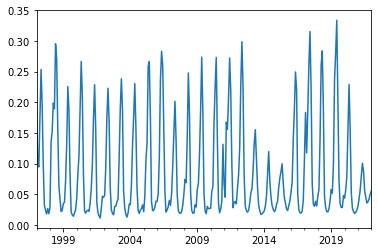

In [6]:
sres_km3.sum(axis = 1).plot()

In [7]:
# Write the sum
sres_km3.sum(axis = 1).to_csv("../data/res_stor_km3.csv")

# Write each individual reservoir 
if not os.path.exists("../data/reservoirs"):
    os.mkdir("../data/reservoirs")
    
sres_km3.to_csv("../data/reservoirs/all_res_km3.csv")


# Write reservoirs shape to /shape/study_area
within_gdf[within_gdf['ID'].isin(sres_km3.columns)].to_file("../shape/study_area/res_within.shp")

<ipython-input-7-977afd0ebaa9>:12: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  within_gdf[within_gdf['ID'].isin(sres_km3.columns)].to_file("../shape/study_area/res_within.shp")


# GET streamflow  for gauges within shapefile

NOTE: Need to preselect the inflow/outflow stations 

API reference found here: https://waterservices.usgs.gov/rest/Statistics-Service-Test-Tool.html


In [8]:
# read stream gauges shapefile 
gauges = gp.read_file("../shape/usgs_gauges.shp")

# Spatial join gauges to study area gdf 
gauges_in_gdf = gp.sjoin(gauges, study_area, how='inner')
gauge_ids = gauges_in_gdf['gauge_id']


<ipython-input-8-3e750f91b8aa>:5: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:4236

  gauges_in_gdf = gp.sjoin(gauges, study_area, how='inner')


In [9]:
def get_streamflow(gauge_ids):
    
    '''
    Query CA DWR website to get MONTHLY reservoir storage for an area of interest
    '''
    print("**** Begin Fetching USGS STREAmflow Data****")
        
    streamflow_dfs = []

    for site_id in gauge_ids[:]:
        print(site_id)
        
        url = "https://waterservices.usgs.gov/nwis/stat/?format=rdb&sites={}&statReportType=monthly&statTypeCd=all&missingData=off&parameterCd=00060".format(str(site_id))
        try:
            df = pd.read_csv(url, skiprows = 32, sep = '\t').iloc[1:]
            # Get year/month as datetime index 
            df['year_nu'] = df['year_nu'].astype(int)
            df['month_nu'] = df['month_nu'].astype(int)
            df['mean_va'] = df['mean_va'].astype(float)

            dts = []
            for y,m in zip(df['year_nu'], df['month_nu']):
                dts.append(datetime.datetime(y,m,1) )

            df.index = dts            

            # convert cfs to cms, then m3 --> km3 then sec --> month
            df['q_km3_mon'] = df['mean_va'] *0.0283168 * 1e-9 * 2629800
            outdf= pd.DataFrame(df['q_km3_mon'])

            outdf.columns = [site_id]

            streamflow_dfs.append(outdf)
        except:
            print(url)
        
    return pd.concat(streamflow_dfs, axis = 1)
        

In [10]:
# streamflow = get_streamflow(gauge_ids)

In [11]:
inflow_stns = ['11208818', '11202838','11204100','11200800', '11199500',]
# outflow_stns = [] # closed basin --> no outflow 

In [12]:
inflow = get_streamflow(inflow_stns)
# outflow = get_streamflow(outflow_stns) # closed basin 

**** Begin Fetching USGS STREAmflow Data****
11208818
11202838
11204100
11200800
11199500


<AxesSubplot:>

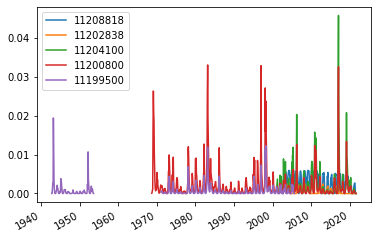

In [13]:
inflow.plot()

<AxesSubplot:>

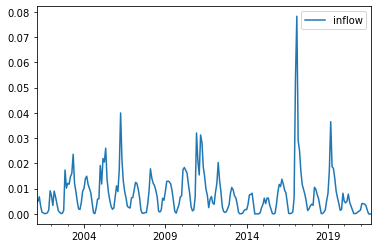

In [14]:
inflow[inflow.index>'2001-01-01'].sum(axis = 1).plot(label = 'inflow', legend = True)
# outflow[outflow.index>'2001-01-01'].sum(axis =1).plot(label = 'outflow', legend = True)

In [15]:
indf = pd.DataFrame(inflow[inflow.index>'2001-01-01'].sum(axis = 1))
indf.columns = ['inflow_km3']
# outdf = pd.DataFrame(outflow[outflow.index>'2001-01-01'].sum(axis = 1))
# outdf.columns = ['outflow_km3']

indf.to_csv("../data/inflow.csv")
# outdf.to_csv("../data/outflow.csv")

In [16]:
# Save 
gauges[gauges['gauge_id'].isin(inflow_stns)].to_file("../shape/study_area/inflow.shp")
# gauges[gauges['gauge_id'].isin(aa_outflow_stns)].to_file("../shape/study_area/outflow.shp")